In [102]:
import numpy as np
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap

le = LabelEncoder()
sd = StandardScaler()

In [2]:
# Genetic Algorithm for knowledge tracing feature selection
class Selector:
    def __init__(self, x, y, pop = 10, gen = 2):
        # x, y 
        self.x = x
        self.y = y
        # parameter settings
        # DNA lengths, corresponding to feature numbers (excluding outcome)
        self.DNA_SIZE = x.shape[1]
        # population size
        self.POP_SIZE = pop
        # generation size
        self.N_GENERATIONS = gen
        # mutation probability
        self.MUTATION_RATE = 0.003  
        # crossover probability
        self.CROSS_RATE = 0.8
        self.best_dna = []


        self.update()

    # ## Step 3: Define fitness, select, crossover, mutate functions
    # define the fitness function
    # The fitness score is obtained by using 5-fold Support Vector Machine (SVM)
    def get_fitness(self,pop):

        acc = []
        for chd in pop:
            # define model
            model = SVC(C=0.5)
            
            # find faetures labelled as 0 in DNA to drop
            drop = []
            
            for i in range(len(chd)):
                if chd[i] == 0:
                    drop.append(i)
                    
            x_data = self.x.copy(deep=True)
            x_data = x_data.drop(x_data.columns[drop], axis=1)
            
            print('DNA Individual: ', chd)
            
            # SVM for fitness computation
            score = cross_validate(model, x_data, self.y, scoring={'accuracy': 'accuracy',
                       'precision': 'precision','recall': 'recall','f1': 'f1'}, cv=5) #peform 5-fold validaiton
            result = {"Acc": np.average(score['test_accuracy']), "Recall": np.average(score['test_recall']),
                       "Precision": np.average(score['test_precision']), "F1": np.average(score['test_f1'])}

            print('Result: ', result)
            acc.append(result["Acc"])
        return acc


    # select new poplation, based on fitness score weighted sampling
    def select(self, pop, fit_scores):
        index = np.random.choice(np.arange(self.POP_SIZE), size=self.POP_SIZE, replace=True,
                           p=fit_scores / sum(fit_scores))
        return pop[index]


    # define DNA crossover 
    def crossover(self, parent, pop):
        # trigger crossover
        if np.random.rand() < self.CROSS_RATE:
            # select another DNA
            idx = np.random.randint(0, self.POP_SIZE, size=1)
            # select DNA bit to cross over
            bits = np.random.randint(0, 2, size=self.DNA_SIZE).astype(np.bool)
            # perform crossover
            parent[bits] = pop[idx, bits]
        return parent


    # denf DNA mutate
    def mutate(self,child):
        for point in range(self.DNA_SIZE):
            if np.random.rand() < self.MUTATION_RATE:
                if child[point] == 1:
                    child[point] == 0
                else:
                    child[point] == 1
        return child

    # the process of GA and update parent & child
    def update(self):
        """
        the whole process of genetic algorithm
        """
        
        # generate population DNA
        pop = np.random.randint(0, 2, (self.POP_SIZE, self.DNA_SIZE))
        
        # repeat n times
        for t in range(self.N_GENERATIONS):
            print("Generation number:", t)
            # retrieve fitness score (SVM accuracy result) for each DNA 
            fit_scores = self.get_fitness(pop) 
            # reach the last generation and report the best
            if t == self.N_GENERATIONS - 1:
                dna_best = pop[np.argmax(fit_scores), :]
                print("Most fitted DNA: ", dna_best)
                self.best_dna = list(dna_best)
                return

            # select better population as parent 1
            pop = self.select(pop, fit_scores)
            # make another copy as parent 2
            pop2 = pop.copy()
            
            # transform child by crossover and mutation
            for par in pop:
                chd = self.crossover(par, pop2)
                chd = self.mutate(chd)
                par[:] = chd

In [3]:
# feature selection helper function
def data_prep(data, num, col_to_drop, outcome, sd_option = 1):
    
    # drop useless features
    data.drop(col_to_drop, axis=1, inplace = True)
    # sample a subset of size-num datasets, regarding to original label distribution
    x_mini = class_subsample(data, outcome, num)
    y_mini = np.array((x_mini[outcome]))
    # hide ground truth
    x_mini = x_mini.drop([outcome], axis=1)

    x_data = pd.DataFrame()

    # fill nan value for the label encoder
    col_num = 0
    for col in x_mini:

        
        re = x_mini[col]
        if x_mini[col].isnull().values.any():
            if x_mini[col].dtype == 'int64':
                mi = x_mini[col].min()
                re = x_mini[col].fillna(int(mi-1))
            elif x_mini[col].dtype == 'float64':
                mi = x_mini[col].min()
                re = x_mini[col].fillna(mi-1.0)
            else:
                re = x_mini[col].fillna(' ')
        print(x_mini.columns[col_num])  
        col_num += 1
        re = le.fit_transform(re)
        x_data[col] = re

        
    # standardise value, just for svm
    if sd_option == 1:
        x_data_sd = sd.fit_transform(x_data)
        x_data = pd.DataFrame(x_data_sd)
    return x_data, y_mini

# count the number of correct and incorrect attempts
def count_class(bin_data, outcome):
    val = [0, 0]
    for i in bin_data[outcome]:
        if i == 1:
            val[1] += 1
        else:
            val[0] += 1
    print("correctness distribution is", val)
    return val

# based on ground truth distribution, return a shuffled sample subset of dataset.
def class_subsample(data, outcome, size, random_state = 14):
    # calculate number of two classes in the sample
    val = count_class(data, outcome)
    ratio = val[1] / (val[0] + val[1])
    true_num = int(size * ratio)
    false_num = size - true_num
    
    # sampling two classes
    x_true = data[data[outcome]==1]
    x_false = data[data[outcome]==0]
    x_true_sp = x_true.sample(n=true_num, random_state=random_state)
    x_false_sp = x_false.sample(n=false_num, random_state=random_state)
    x_sp = x_true_sp.append(x_false_sp, ignore_index=True)
    x_sp = shuffle(x_sp, random_state=random_state)
    val = count_class(x_sp, outcome)
    return x_sp

In [23]:
# dataset 1 Ass 09
path = "DataResult/ass09.csv"
num = 10000
outcome = 'correct'
data = pd.read_csv(path, low_memory=False, nrows = 1000000)
# inspection of dataset -- can be skipped -- done this to reduce computational cost
print(data.columns)
print(data.info())
# print(data['opportunity_original'].nunique())
# drop some unrelevant features to reduce computational times
# a features will be dropped if is almost empty, only have 1 value, and record id/index features
col_to_drop = ['Unnamed: 0','order_id', 'hint_count', 'hint_total', 'bottom_hint', 'answer_id', 'type']

Index(['Unnamed: 0', 'order_id', 'assignment_id', 'user_id', 'assistment_id',
       'problem_id', 'original', 'correct', 'attempt_count',
       'ms_first_response', 'tutor_mode', 'answer_type', 'sequence_id',
       'student_class_id', 'position', 'type', 'base_sequence_id', 'skill_id',
       'skill_name', 'teacher_id', 'school_id', 'hint_count', 'hint_total',
       'overlap_time', 'template_id', 'answer_id', 'answer_text',
       'first_action', 'bottom_hint', 'opportunity', 'opportunity_original'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346860 entries, 0 to 346859
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            346860 non-null  int64  
 1   order_id              346860 non-null  int64  
 2   assignment_id         346860 non-null  int64  
 3   user_id               346860 non-null  int64  
 4   assistment_id         346860 non-null  i

In [69]:
print(data['Average_confidence(BORED)'].unique())

[0.         0.442968   0.912281   ... 0.45332281 0.15070712 0.29834867]


In [31]:
# dataset 3 Ass 12
path = "DataResult/ass12.csv"
num = 10000
outcome = 'correct'
data = pd.read_csv(path, low_memory=False, nrows = 1000000)
# inspection of dataset -- can be skipped -- done this to reduce computational cost
print(data.columns)
print(data.info())
# print(data['opportunity_original'].nunique())
# drop some unrelevant features to reduce computational times
# a features will be dropped if is almost empty, only have 1 value, and record id/index features
col_to_drop = ['Unnamed: 0','problem_log_id', 'hint_count', 'bottom_hint', 'answer_id']

Index(['Unnamed: 0', 'problem_log_id', 'skill', 'problem_id', 'user_id',
       'assignment_id', 'assistment_id', 'start_time', 'end_time',
       'problem_type', 'original', 'correct', 'bottom_hint', 'hint_count',
       'actions', 'attempt_count', 'ms_first_response', 'tutor_mode',
       'sequence_id', 'student_class_id', 'position', 'type',
       'base_sequence_id', 'skill_id', 'teacher_id', 'school_id',
       'overlap_time', 'template_id', 'answer_id', 'answer_text',
       'first_action', 'problemlogid', 'Average_confidence(FRUSTRATED)',
       'Average_confidence(CONFUSED)', 'Average_confidence(CONCENTRATING)',
       'Average_confidence(BORED)'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 36 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Unnamed: 0                         1000000 non-null  int64  
 1 

In [4]:
# dataset 3 Ass 15
path = "DataResult/ass15.csv"
num = 10000
outcome = 'correct'
data = pd.read_csv(path, low_memory=False)
# inspection of dataset -- can be skipped -- done this to reduce computational cost
# print(data.columns)
# print(data.info())
# print(data['opportunity_original'].nunique())
# drop some unrelevant features to reduce computational times
# a features will be dropped if is almost empty, only have 1 value, and record id/index features
print(data.columns)
print(data.info())
col_to_drop = ['Unnamed: 0']

Index(['Unnamed: 0', 'user_id', 'log_id', 'sequence_id', 'correct'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708631 entries, 0 to 708630
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   708631 non-null  int64  
 1   user_id      708631 non-null  int64  
 2   log_id       708631 non-null  int64  
 3   sequence_id  708631 non-null  int64  
 4   correct      708631 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 27.0 MB
None


In [74]:
# data
count = 0
for col in data.columns:
    print(count, data[col].nunique())
    count += 1
    

0 942816
1 1709
2 4
3 2
4 2
5 1709
6 1709
7 1598
8 921
9 1709
10 1709
11 1709
12 1709
13 1709
14 1709
15 942816
16 102
17 3162
18 16
19 268
20 2286
21 665163
22 663889
23 9632
24 2
25 2
26 2
27 57
28 41
29 2
30 2
31 91
32 2
33 6
34 9
35 2
36 9
37 1717
38 74
39 6
40 9
41 9251
42 52844
43 2
44 1379
45 222
46 2
47 1
48 2
49 2
50 3511
51 106
52 1462
53 2
54 2
55 963
56 2
57 2
58 57
59 86477
60 57028
61 378746
62 6
63 2
64 2
65 3
66 46575
67 13
68 15
69 19
70 5736
71 4
72 48944
73 16
74 19
75 24
76 6304
77 109083
78 120112
79 52
80 2
81 2
82 2


In [61]:
# dataset 4 Assch
path = "DataResult/assch.csv"
num = 10000
outcome = 'correct'
data = pd.read_csv(path, low_memory=False)
print(data.columns)
print(data.info())
col_to_drop = ['Unnamed: 0']

Index(['Unnamed: 0', 'studentId', 'MiddleSchoolId', 'InferredGender',
       'SY ASSISTments Usage', 'AveKnow', 'AveCarelessness', 'AveCorrect',
       'NumActions', 'AveResBored', 'AveResEngcon', 'AveResConf',
       'AveResFrust', 'AveResOfftask', 'AveResGaming', 'action_num', 'skill',
       'problemId', 'problemType', 'assignmentId', 'assistmentId', 'startTime',
       'endTime', 'timeTaken', 'correct', 'original', 'hint', 'hintCount',
       'hintTotal', 'scaffold', 'bottomHint', 'attemptCount',
       'frIsHelpRequest', 'frPast5HelpRequest', 'frPast8HelpRequest',
       'stlHintUsed', 'past8BottomOut', 'totalFrPercentPastWrong',
       'totalFrPastWrongCount', 'frPast5WrongCount', 'frPast8WrongCount',
       'totalFrTimeOnSkill', 'timeSinceSkill', 'frWorkingInSchool',
       'totalFrAttempted', 'totalFrSkillOpportunities', 'responseIsFillIn',
       'responseIsChosen', 'endsWithScaffolding', 'endsWithAutoScaffolding',
       'frTimeTakenOnScaffolding', 'frTotalSkillOpportunitiesS

In [24]:
# dataset 5 Stat
path = "DataResult/stat.csv"
num = 10000
outcome = 'Outcome'
data = pd.read_csv(path, low_memory=False)
print(data.columns)
print(data.info())
col_to_drop = ['Unnamed: 0', 'CF (oli:purpose)', 'CF (oli:resourceType)', 'Problem Step Name','CF (oli:activityGuid)',
'CF (oli:highStakes)','Input.1', 'Student Response Subtype', 'Tutor Response Subtype', 'Level (Section1)', 'Feedback Classification'
              , 'Help Level', 'Total Num Hints', 'KC Category (Single-KC)' , 'KC Category (Unique-step)','KC Category (F2011)', 'Feedback Text']

Index(['Unnamed: 0', 'Row', 'Sample Name', 'Transaction Id', 'Anon Student Id',
       'Session Id', 'Time', 'Time Zone', 'Duration (sec)',
       'Student Response Type', 'Student Response Subtype',
       'Tutor Response Type', 'Tutor Response Subtype', 'Level (Sequence)',
       'Level (Unit)', 'Level (Module)', 'Level (Section1)', 'Problem Name',
       'Problem View', 'Problem Start Time', 'Step Name', 'Attempt At Step',
       'Is Last Attempt', 'Outcome', 'Selection', 'Action', 'Input', 'Input.1',
       'Feedback Text', 'Feedback Classification', 'Help Level',
       'Total Num Hints', 'KC (Single-KC)', 'KC Category (Single-KC)',
       'KC (Unique-step)', 'KC Category (Unique-step)', 'KC (F2011)',
       'KC Category (F2011)', 'KC (F2011).1', 'KC Category (F2011).1',
       'KC (F2011).2', 'KC Category (F2011).2', 'School', 'Class',
       'CF (oli:activityGuid)', 'CF (oli:highStakes)', 'CF (oli:purpose)',
       'CF (oli:resourceType)', 'Problem Step Name'],
      dtype='obje

In [69]:
# dataset 6 junyi10
path = "DataResult/junyi10.csv"
num = 10000
outcome = 'correct'
data = pd.read_csv(path, low_memory=False, nrows = 100000)
print(data.columns)
print(data.info())
col_to_drop = ['Unnamed: 0','index', 'hint_time_taken_list', 'count_hints', 'hint_used']

Index(['Unnamed: 0', 'index', 'user_id', 'exercise', 'problem_type',
       'problem_number', 'topic_mode', 'suggested', 'review_mode', 'time_done',
       'time_taken', 'time_taken_attempts', 'correct', 'count_attempts',
       'hint_used', 'count_hints', 'hint_time_taken_list',
       'earned_proficiency', 'points_earned'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            100000 non-null  int64  
 1   index                 100000 non-null  int64  
 2   user_id               100000 non-null  int64  
 3   exercise              100000 non-null  object 
 4   problem_type          100000 non-null  object 
 5   problem_number        100000 non-null  int64  
 6   topic_mode            100000 non-null  bool   
 7   suggested             100000 non-null  bool   
 8   review_mode    

In [22]:
data['earned_proficiency'].unique()

array([False,  True])

In [19]:
# dataset 7 junyi18
path = "DataResult/junyi18.csv"
num = 10000
outcome = 'is_correct'
data = pd.read_csv(path, low_memory=False, nrows = 100000)

col_to_drop = ['is_downgrade', 'is_upgrade']

In [118]:
# dataset 8 poj
path = "DataResult/poj.csv"
num = 10000
outcome = 'Result'
data = pd.read_csv(path, low_memory=False)
print(data.columns)
print(data.info())
col_to_drop = ['Unnamed: 0']


In [85]:
# dataset 9 alg05
path = "DataResult/alg05.csv"
num = 10000
outcome = 'Correct First Attempt'
data = pd.read_csv(path, low_memory=False)
print(data.columns)
print(data.info())
col_to_drop = ['Row','Incorrects', 'Hints', 'Corrects',]
col_to_drop = ['Row','Incorrects', 'Hints', 'Corrects', 'Correct Step Duration (sec)', 'Error Step Duration (sec)', 'Step Duration (sec)', 'Correct Transaction Time']

Index(['Row', 'Anon Student Id', 'Problem Hierarchy', 'Problem Name',
       'Problem View', 'Step Name', 'Step Start Time',
       'First Transaction Time', 'Correct Transaction Time', 'Step End Time',
       'Step Duration (sec)', 'Correct Step Duration (sec)',
       'Error Step Duration (sec)', 'Correct First Attempt', 'Incorrects',
       'Hints', 'Corrects', 'KC(Default)', 'Opportunity(Default)',
       'Problem Step Name'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542069 entries, 0 to 542068
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Row                          542069 non-null  int64  
 1   Anon Student Id              542069 non-null  object 
 2   Problem Hierarchy            542069 non-null  object 
 3   Problem Name                 542069 non-null  object 
 4   Problem View                 542069 non-null  int64  
 5   Step Name     

In [31]:
val = []
for i in data['Correct Step Duration (sec)']:
    if not np.isnan(i):
        val.append(int(i*10))
    else:
        val.append(-1)
print(len(val))
data['csdi'] = val

val = []
for i in data['Step Duration (sec)']:
    if not np.isnan(i):
        val.append(int(i*10))
    else:
        val.append(-1)
print(len(set(val)))
data['sdi'] = val

print(data.info())
data.to_csv("alg05_i.csv",index = False)

542069
1126
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542069 entries, 0 to 542068
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Row                          542069 non-null  int64  
 1   Anon Student Id              542069 non-null  object 
 2   Problem Hierarchy            542069 non-null  object 
 3   Problem Name                 542069 non-null  object 
 4   Problem View                 542069 non-null  int64  
 5   Step Name                    542069 non-null  object 
 6   Step Start Time              541627 non-null  object 
 7   First Transaction Time       542069 non-null  object 
 8   Correct Transaction Time     532397 non-null  object 
 9   Step End Time                542069 non-null  object 
 10  Step Duration (sec)          541627 non-null  float64
 11  Correct Step Duration (sec)  455211 non-null  float64
 12  Error Step Duration (sec)    86416 non-null   

In [99]:
# dataset 10 alg06
path = "DataResult/alg06.csv"
num = 10000
outcome = 'Correct First Attempt'
data = pd.read_csv(path, low_memory=False)
print(data.columns)
print(data.info())
col_to_drop = ['Row','Incorrects', 'Hints', 'Corrects',]


Index(['Row', 'Anon Student Id', 'Problem Hierarchy', 'Problem Name',
       'Problem View', 'Step Name', 'Step Start Time',
       'First Transaction Time', 'Correct Transaction Time', 'Step End Time',
       'Step Duration (sec)', 'Correct Step Duration (sec)',
       'Error Step Duration (sec)', 'Correct First Attempt', 'Incorrects',
       'Hints', 'Corrects', 'KC(Default)', 'Opportunity(Default)',
       'Problem Step Name'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652884 entries, 0 to 1652883
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Row                          1652884 non-null  int64  
 1   Anon Student Id              1652884 non-null  object 
 2   Problem Hierarchy            1652884 non-null  object 
 3   Problem Name                 1652884 non-null  object 
 4   Problem View                 1652884 non-null  int64  
 5   Step 

In [200]:
print(data['Correct Step Duration (sec)'].unique())
data
for i in data['Correct Step Duration (sec)']

[1.60000e+01 2.20000e+01 1.18000e+02         nan 1.20000e+01 5.00000e+00
 4.60000e+01 1.50000e+01 8.00000e+00 1.30000e+01 1.00000e+01 7.20000e+01
 6.00000e+00 9.00000e+00 7.00000e+00 1.10000e+01 2.00000e+01 5.80000e+01
 3.90000e+01 2.10000e+01 2.50000e+01 2.30000e+01 4.40000e+01 1.40000e+01
 4.10000e+01 2.90000e+01 3.60000e+01 8.20000e+01 1.05000e+02 8.90000e+01
 1.90000e+01 3.30000e+01 3.00000e+01 7.50000e+01 2.40000e+01 4.70000e+01
 2.80000e+01 4.80000e+01 7.60000e+01 3.70000e+01 6.70000e+01 2.60000e+01
 2.55000e+02 9.20000e+01 3.20000e+01 4.00000e+00 1.04000e+02 6.40000e+01
 1.14000e+02 6.30000e+01 1.80000e+01 7.30000e+01 4.90000e+01 3.10000e+01
 5.40000e+01 1.70000e+01 6.50000e+01 1.76000e+02 1.02000e+02 1.67000e+02
 6.20000e+01 5.00000e+01 3.00000e+00 7.80000e+01 6.60000e+01 3.40000e+01
 1.40000e+02 2.00000e+00 1.00000e+00 2.70000e+01 4.20000e+01 9.50000e+01
 1.11000e+02 5.60000e+01 5.00000e-01 1.10000e+02 3.80000e+01 3.50000e+01
 2.63000e+02 4.50000e+01 1.52000e+02 1.65000e+01 4.

In [5]:
print(data.columns)


Index(['Unnamed: 0', 'order_id', 'assignment_id', 'user_id', 'assistment_id',
       'problem_id', 'original', 'correct', 'attempt_count',
       'ms_first_response', 'tutor_mode', 'answer_type', 'sequence_id',
       'student_class_id', 'position', 'type', 'base_sequence_id', 'skill_id',
       'skill_name', 'teacher_id', 'school_id', 'hint_count', 'hint_total',
       'overlap_time', 'template_id', 'answer_id', 'answer_text',
       'first_action', 'bottom_hint', 'opportunity', 'opportunity_original'],
      dtype='object')


In [29]:
# dataset 11 algbg
path = "DataResult/algbg.csv"
num = 10000
outcome = 'Correct First Attempt'
data = pd.read_csv(path, low_memory=False)
print(data.columns)
print(data.info())
col_to_drop = ['Unnamed: 0', 'Row','Incorrects', 'Hints', 'Corrects', 'Step Duration (sec)', 'Correct Step Duration (sec)', 'Error Step Duration (sec)']

Index(['Unnamed: 0', 'Row', 'Anon Student Id', 'Problem Hierarchy',
       'Problem Name', 'Problem View', 'Step Name', 'Step Start Time',
       'First Transaction Time', 'Correct Transaction Time', 'Step End Time',
       'Step Duration (sec)', 'Correct Step Duration (sec)',
       'Error Step Duration (sec)', 'Correct First Attempt', 'Incorrects',
       'Hints', 'Corrects', 'KC(SubSkills)', 'Opportunity(SubSkills)',
       'Problem Step Name'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738955 entries, 0 to 1738954
Data columns (total 21 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Unnamed: 0                   int64  
 1   Row                          int64  
 2   Anon Student Id              object 
 3   Problem Hierarchy            object 
 4   Problem Name                 object 
 5   Problem View                 int64  
 6   Step Name                    object 
 7   Step Start Time              

In [60]:

# col_to_drop = []
x, y = data_prep(data, num, col_to_drop, outcome)
print(x.info())
# col_to_drop = []
print(x.shape, y.shape)
print(x.columns)
print(len(x.columns))

# print(x['User'].nunique())
# print(x['Submit Time'].nunique())
# print(x['Problem'].nunique())
best_DNA = Selector(x, y)
# print(data.info())
# print("prep_done")
# print(x.head())
# print(y[0:100])
# print(x.info())
# x_mmm = x[['Anon Student Id', 'Time', 'Duration (sec)','Problem Name', 'Is Last Attempt']]
# model = SVC(C=1)
# x_mmmmm = x[['Problem']]
# scores = cross_validate(model, x_mmmmm, y, scoring={'accuracy': 'accuracy',
#                        'precision': 'precision',
#                        'recall': 'recall',
#                        'f1': 'f1'}, cv=5)
# print(scores)
# print(best_DNA)
# bd = best_DNA.best_dna
# print(best_DNA.best_dna)

correctness distribution is [591446, 351370]
correctness distribution is [6274, 3726]
studentId
MiddleSchoolId
InferredGender
SY ASSISTments Usage
AveKnow
AveCarelessness
AveCorrect
NumActions
AveResBored
AveResEngcon
AveResConf
AveResFrust
AveResOfftask
AveResGaming
action_num
skill
problemId
problemType
assignmentId
assistmentId
startTime
endTime
timeTaken
original
hint
hintCount
hintTotal
scaffold
bottomHint
attemptCount
frIsHelpRequest
frPast5HelpRequest
frPast8HelpRequest
stlHintUsed
past8BottomOut
totalFrPercentPastWrong
totalFrPastWrongCount
frPast5WrongCount
frPast8WrongCount
totalFrTimeOnSkill
timeSinceSkill
frWorkingInSchool
totalFrAttempted
totalFrSkillOpportunities
responseIsFillIn
responseIsChosen
endsWithScaffolding
endsWithAutoScaffolding
frTimeTakenOnScaffolding
frTotalSkillOpportunitiesScaffolding
totalFrSkillOpportunitiesByScaffolding
frIsHelpRequestScaffolding
timeGreater5Secprev2wrong
sumRight
helpAccessUnder2Sec
timeGreater10SecAndNextActionRight
consecutiveErrorsI

KeyboardInterrupt: 

In [ ]:
print([1]*30)

In [71]:
# helper function for xgboost & shap
def ft_selection(col_index, col_names):
    col_selected = []
    print(len(col_names))
    for i in range(len(col_names)):

        if col_index[i] == 1:
            col_selected.append(col_names[i])
    return col_selected

# b_d = best_DNA.best_dna
b_d = [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0]
b_d = [1,1,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,1,1,0,0]
b_d = [0,1,1,1,1,0,0,0,0,1,1,1,1,0,1,0,1,0,0]
b_d = [1,0,0,1,0,0,1,1,1,0,1]
b_d = [1]*80

data_no_label = data.drop([outcome], axis=1)
data_clean = data_no_label.drop(col_to_drop, axis=1)
labels = ft_selection(b_d, data_clean.columns)
labels.append(outcome)
print(labels)



13
['user_id', 'exercise', 'problem_type', 'problem_number', 'topic_mode', 'suggested', 'review_mode', 'time_done', 'time_taken', 'time_taken_attempts', 'count_attempts', 'earned_proficiency', 'points_earned', 'correct']


In [72]:
print(data['Problem Name'].nunique())

KeyError: 'Problem Name'

In [30]:
print(data_clean.columns)

Index(['skill', 'problem_id', 'user_id', 'assignment_id', 'assistment_id',
       'start_time', 'end_time', 'problem_type', 'original', 'actions',
       'attempt_count', 'ms_first_response', 'tutor_mode', 'sequence_id',
       'student_class_id', 'position', 'type', 'base_sequence_id', 'skill_id',
       'teacher_id', 'school_id', 'overlap_time', 'template_id', 'answer_text',
       'first_action', 'problemlogid', 'Average_confidence(FRUSTRATED)',
       'Average_confidence(CONFUSED)', 'Average_confidence(CONCENTRATING)',
       'Average_confidence(BORED)'],
      dtype='object')


In [73]:
b_d = [1]*100

data_no_label = data.drop([outcome], axis=1)
data_clean = data_no_label.drop(col_to_drop, axis=1)
labels = ft_selection(b_d, data_clean.columns)
labels.append(outcome)
print(labels)

data_selected = data[labels]

print(data_selected.info())

x, y = data_prep(data_selected, 100000, [], outcome, 0)
print(x.shape)
print(y.shape)
print(x.info())
selected_cols = x.columns


13
['user_id', 'exercise', 'problem_type', 'problem_number', 'topic_mode', 'suggested', 'review_mode', 'time_done', 'time_taken', 'time_taken_attempts', 'count_attempts', 'earned_proficiency', 'points_earned', 'correct']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              100000 non-null  int64  
 1   exercise             100000 non-null  object 
 2   problem_type         100000 non-null  object 
 3   problem_number       100000 non-null  int64  
 4   topic_mode           100000 non-null  bool   
 5   suggested            100000 non-null  bool   
 6   review_mode          100000 non-null  bool   
 7   time_done            100000 non-null  int64  
 8   time_taken           100000 non-null  int64  
 9   time_taken_attempts  100000 non-null  object 
 10  count_attempts       100000 non-null  int64  
 11  e

In [100]:
labels =['Row', 'Anon Student Id', 'Problem Hierarchy', 
       'Problem View', 'Step Start Time', 'Opportunity(Default)',
       'Problem Step Name', 'Correct First Attempt']
data_selected = data[labels]

print(data_selected.info())

x, y = data_prep(data_selected, 100000, [], outcome, 0)
print(x.shape)
print(y.shape)
print(x.info())
selected_cols = x.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652884 entries, 0 to 1652883
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Row                    1652884 non-null  int64  
 1   Anon Student Id        1652884 non-null  object 
 2   Problem Hierarchy      1652884 non-null  object 
 3   Problem View           1652884 non-null  int64  
 4   Step Start Time        1651641 non-null  object 
 5   Opportunity(Default)   1652884 non-null  object 
 6   Problem Step Name      1652884 non-null  object 
 7   Correct First Attempt  1652884 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 100.9+ MB
None
correctness distribution is [249673, 1403211]
correctness distribution is [15106, 84894]
Row
Anon Student Id
Problem Hierarchy
Problem View
Step Start Time
Opportunity(Default)
Problem Step Name
(100000, 7)
(100000,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entri

In [97]:
print(data['points_earned'].unique())

KeyError: 'points_earned'

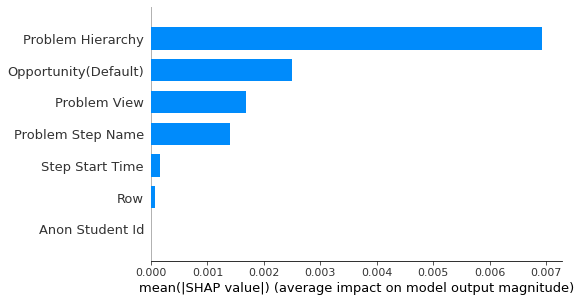

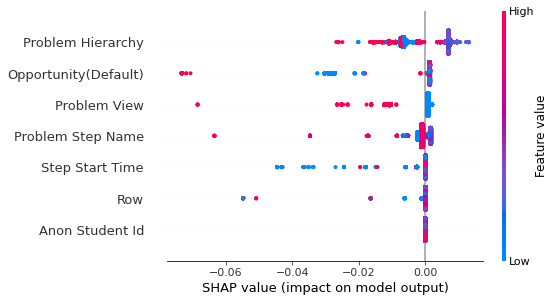

<Figure size 432x288 with 0 Axes>

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=14)
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

model.fit(x_train,y_train)

res = model.predict(x_test)

# print(res)

# importance_all = pd.DataFrame()
# for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
#     importance = trained_xgb.get_booster().get_score(importance_type=importance_type)
#     keys = list(importance.keys())
#     values = list(importance.values())
#     df_importance = pd.DataFrame(data=values, index=keys, columns=['importance_'+importance_type])
#     importance_all = pd.concat([importance_all, df_importance],axis=1)
# print(importance_all)

explain = shap.TreeExplainer(model) # get explainer
shap_v = explain.shap_values(x[selected_cols]) # get SHAP values from each instance of each feature

y_base = explain.expected_value

plt.tight_layout()

shap.summary_plot(shap_v, x[selected_cols],feature_names=selected_cols,plot_type="bar")

plt.show()
plt.savefig("ass09_1.png")
plt.tight_layout()

shap.summary_plot(shap_v, x[selected_cols],feature_names=selected_cols)
plt.show()

plt.savefig("ass09_2.png")
# plt.savefig('ADM_BAR_PLOT.png', format='png', dpi=1200, bbox_inches='tight')

In [54]:
# print(x_sd)
# x_sd_pd = pd.DataFrame(x_sd)
# print(x_sd_pd)
# print(x_t)
b_d = Selector(x_sd_pd, y)


NameError: name 'x_sd_pd' is not defined

In [193]:
correctness distribution is [44414, 144883]
Tutor Response Type
Level (Sequence)
Problem Name
Action
Input
Input.1
Feedback Text
Feedback Classification
Help Level
Total Num Hints
KC (Single-KC)
KC (Unique-step)
KC Category (Unique-step)
KC (F2011)
KC Category (F2011)
KC (F2011).1
KC Category (F2011).1
KC (F2011).2
KC Category (F2011).2
School
CF (oli:highStakes)
CF (oli:purpose)

SyntaxError: invalid syntax (<ipython-input-193-1d90e4dcf03f>, line 1)

In [170]:
model = SVC(C=1)
model.fit(x[['Problem']], y)
model.predict(x[['Problem']])

array([0, 0, 0, ..., 0, 0, 0])

In [92]:
#Start time 6:46
#End time 6:56
#for 100 population 1 generation


#start time 7:00
#end time 8:20
#for 50 population, 20 generation
#Most fitted DNA:  [0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1]
# mfDNA = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]
mfDNA = [1,1,0,0,0,0,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,1,1,0,0]
selected = []
i = 0
for c in x.columns:
    if mfDNA[i] == 1:
        selected.append(c)
    i += 1   
print(selected)


['assignment_id', 'user_id', 'ms_first_response', 'tutor_mode', 'sequence_id', 'student_class_id', 'position', 'skill_id', 'skill_name', 'hint_total', 'overlap_time', 'template_id', 'answer_text', 'first_action']


In [18]:
# start time 10:00
# end time 11:40
# Most fitted DNA:  [0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0]
mfDNA = [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0]
selected = []
i = 0
for c in x.columns:
    if mfDNA[i] == 1:
        selected.append(c)
    i += 1   
print(selected)

['assignment_id', 'problem_id', 'ms_first_response', 'answer_type', 'skill_id', 'school_id', 'hint_count', 'overlap_time', 'answer_text']


In [ ]:
Ass09
The Generation number is  8
Individual:  [1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0]
Result:  {'Acc': 0.6756, 'Recall': 0.9688463362936008, 'Precision': 0.6725898708474267, 'F1': 0.7939800715134393}
Individual:  [1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0]
Result:  {'Acc': 0.6753, 'Recall': 0.9649716883132479, 'Precision': 0.6733085940752931, 'F1': 0.793175026848467}
Individual:  [1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0]
Result:  {'Acc': 0.6753, 'Recall': 0.9649716883132479, 'Precision': 0.6733085940752931, 'F1': 0.793175026848467}
Individual:  [0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 0]
Result:  {'Acc': 0.6723000000000001, 'Recall': 0.9818655089798787, 'Precision': 0.6671943919389002, 'F1': 0.794502983545061}
Individual:  [1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0]
Result:  {'Acc': 0.8606999999999999, 'Recall': 1.0, 'Precision': 0.8225129818960178, 'F1': 0.9025929191643389}
Individual:  [1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 0]
Result:  {'Acc': 0.6756, 'Recall': 0.9804707606026215, 'Precision': 0.6698439094235379, 'F1': 0.7959207650049215}
Individual:  [1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0]
Result:  {'Acc': 0.6452, 'Recall': 1.0, 'Precision': 0.6452, 'F1': 0.7843423022538213}
Individual:  [1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0]
Result:  {'Acc': 0.6452, 'Recall': 1.0, 'Precision': 0.6452, 'F1': 0.7843423022538213}
Individual:  [0 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0]
Result:  {'Acc': 0.6726, 'Recall': 0.9817104702201889, 'Precision': 0.667439263222701, 'F1': 0.7946265665588979}
Individual:  [1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0]
Result:  {'Acc': 0.8583000000000001, 'Recall': 1.0, 'Precision': 0.8199941336830436, 'F1': 0.9010769813466757}
Individual:  [0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1]
Result:  {'Acc': 0.6728000000000001, 'Recall': 0.9812455941250999, 'Precision': 0.6676845816154262, 'F1': 0.7946489246667798}
Individual:  [0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 0]
Result:  {'Acc': 0.6726000000000001, 'Recall': 0.98140063288479, 'Precision': 0.6675095493185305, 'F1': 0.7945752771714018}
Individual:  [1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1]
Result:  {'Acc': 0.8592000000000001, 'Recall': 1.0, 'Precision': 0.820945457396201, 'F1': 0.901647706927131}
Individual:  [1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1]
Result:  {'Acc': 0.8588000000000001, 'Recall': 1.0, 'Precision': 0.8205208368084467, 'F1': 0.901393417173576}
Individual:  [0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0]
Result:  {'Acc': 0.8593, 'Recall': 1.0, 'Precision': 0.8210511342070221, 'F1': 0.9017111228634084}
Individual:  [1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0]
Result:  {'Acc': 0.8583000000000001, 'Recall': 1.0, 'Precision': 0.8199941336830436, 'F1': 0.9010769813466757}
Individual:  [1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1]
Result:  {'Acc': 0.6452, 'Recall': 1.0, 'Precision': 0.6452, 'F1': 0.7843423022538213}
Individual:  [1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 1]
Result:  {'Acc': 0.8592000000000001, 'Recall': 1.0, 'Precision': 0.820945457396201, 'F1': 0.901647706927131}
Individual:  [1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0]